# Deep Learning for Computer Vision: Project

In [2]:
from torch.utils.data import Dataset, DataLoader #, random_split
from torchvision.models import ResNet18_Weights, DenseNet121_Weights
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torchvision
import torch

In [3]:
training_dir = "./datasets/training"
validation_dir = "./datasets/validation"
test_dir = "./datasets/test"

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

training_set = torchvision.datasets.ImageFolder(root=training_dir, transform=data_transform)
validation_set = torchvision.datasets.ImageFolder(root=validation_dir, transform=data_transform)
test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transform)

idx_to_class = {v:k for k,v in training_set.class_to_idx.items()}
print(idx_to_class)

{0: 'animal', 1: 'architecture', 2: 'fastfood', 3: 'person', 4: 'plant', 5: 'vehicle'}


In [9]:
training_dataloader = DataLoader(training_set, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

Actual label: vehicle


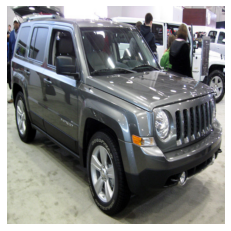

In [12]:
for value in training_dataloader:
    data, label = value
    print("Actual label:", idx_to_class[int(label.item())])
    plt.imshow(torch.squeeze(data).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/cg3320/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
resnet18.fc = nn.Linear(512, 6)

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        predict = model(X)
        loss = loss_fn(predict, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"step: {current:>5d}/{size:>5d} loss: {loss:>7f}")

In [17]:
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            predict = model(X)
            test_loss += loss_fn(predict, y).item()
            correct += (predict.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Training Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [18]:
model = resnet18.to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [21]:
epochs = 5

for t in range(epochs):
    print("Epoch", t+1)
    train(training_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model, loss_fn)

Epoch 1
step:     0/10200 loss: 2.123932
step:   500/10200 loss: 1.727625
step:  1000/10200 loss: 1.709833
step:  1500/10200 loss: 1.714869
step:  2000/10200 loss: 0.966824
step:  2500/10200 loss: 1.705031
step:  3000/10200 loss: 1.626717
step:  3500/10200 loss: 0.865440
step:  4000/10200 loss: 0.686126
step:  4500/10200 loss: 0.429876
step:  5000/10200 loss: 1.022388
step:  5500/10200 loss: 0.672554
step:  6000/10200 loss: 0.978723
step:  6500/10200 loss: 0.296340
step:  7000/10200 loss: 0.616845
step:  7500/10200 loss: 0.209384
step:  8000/10200 loss: 0.188734
step:  8500/10200 loss: 0.222414
step:  9000/10200 loss: 0.178727
step:  9500/10200 loss: 2.047699
step: 10000/10200 loss: 0.880479
Training Accuracy: 63.7%, Avg loss: 1.415132

Epoch 2
step:     0/10200 loss: 1.543326
step:   500/10200 loss: 0.000004
step:  1000/10200 loss: 0.000660
step:  1500/10200 loss: 0.000056
step:  2000/10200 loss: 0.002967
step:  2500/10200 loss: 4.612134
step:  3000/10200 loss: 0.146860
step:  3500/10

In [22]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    wrong = []
    wrong_prediction = []
    actual = []

    with torch.no_grad():
        for value in dataloader:
            X, label = value
            X = X.to(device)
            y_prediction = model(X).cpu().data.numpy().argmax()
            if y_prediction == label:
              correct += 1
            else:
              wrong.append(X)
              wrong_prediction.append(y_prediction)
              actual.append(label)

    print("test accuracy: %.1f%%\n\n" % (100*correct/size))

    for i in range(3):
      print("Predict label:", idx_to_class[wrong_prediction[i]], ", Actual label:", idx_to_class[int(actual[i])])
      plt.imshow(torch.squeeze(wrong[i].cpu()).permute(1, 2, 0))
      plt.axis("off")
      plt.show()

test accuracy: 96.0%


Predict label: plant , Actual label: fastfood


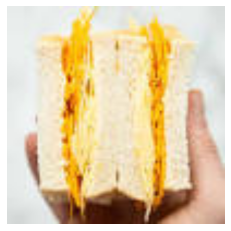

Predict label: plant , Actual label: fastfood


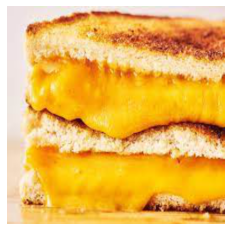

Predict label: plant , Actual label: animal


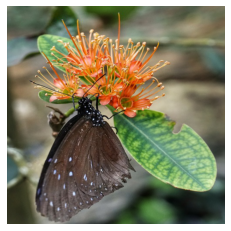

In [24]:
test(test_dataloader, model)

In [25]:
densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

densenet121.classifier = nn.Linear(1024, 6)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/cg3320/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [26]:
model_densenet = densenet121.to(device)

In [27]:
loss_densenet = nn.CrossEntropyLoss()
optimizer_densenet = torch.optim.Adam(model_densenet.parameters(), lr=0.00001)

In [28]:
epochs = 5

for t in range(epochs):
    print("Epoch", t+1)
    train(training_dataloader, model_densenet, loss_densenet, optimizer_densenet)
    validation(validation_dataloader, model_densenet, loss_densenet)

Epoch 1
step:     0/10200 loss: 1.575881
step:   500/10200 loss: 1.799827
step:  1000/10200 loss: 1.794186
step:  1500/10200 loss: 1.650645
step:  2000/10200 loss: 1.310154
step:  2500/10200 loss: 1.495090
step:  3000/10200 loss: 1.567952
step:  3500/10200 loss: 1.614386
step:  4000/10200 loss: 0.902694
step:  4500/10200 loss: 1.055560
step:  5000/10200 loss: 0.641155
step:  5500/10200 loss: 0.784775
step:  6000/10200 loss: 0.684255
step:  6500/10200 loss: 0.681036
step:  7000/10200 loss: 0.794939
step:  7500/10200 loss: 0.823696
step:  8000/10200 loss: 0.569004
step:  8500/10200 loss: 1.675150
step:  9000/10200 loss: 0.501683
step:  9500/10200 loss: 0.325207
step: 10000/10200 loss: 2.242078
Training Accuracy: 21.4%, Avg loss: 2.282817

Epoch 2
step:     0/10200 loss: 1.772273
step:   500/10200 loss: 0.000884
step:  1000/10200 loss: 0.000193
step:  1500/10200 loss: 0.000117
step:  2000/10200 loss: 0.007212
step:  2500/10200 loss: 0.000003
step:  3000/10200 loss: 0.001154
step:  3500/10